# Calculating the FIM Matrix

This notebook calculates the FIM matrix for a small MLP after learning the MNIST dataset.

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils import mlp,train_test_model
from time import time
from data.permuted_MNIST import get_permuted_mnist

In [2]:
import os

results_folder='./Error_Analysis/'
checkpoints='./saved_models/'

if not os.path.isdir(results_folder):
    os.mkdir(results_folder)
if not os.path.isdir(checkpoints):
    os.mkdir(checkpoints)

Set the config

In [3]:
epochs = 50
lr = 1e-4 
batch_size = 100 
input_size = 784
hidden_sizes = [64,32,16] # This is the network architecture 784->[64->32->16]->10
output_size = 10

num_task = 2
n_slices = 100

activation='ReLU'
device='cuda:0'

np.random.seed(0)
torch.manual_seed(0)

Load MNIST (Here I only use the actual MNIST) but we can redo the experiment with the permuted MNIST.

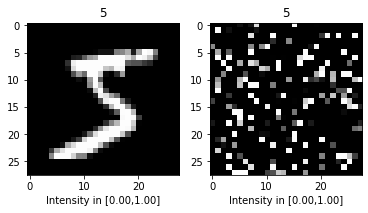

In [4]:
train_loader, test_loader = get_permuted_mnist(num_task,batch_size)

fig,ax=plt.subplots(1,num_task,figsize=(num_task*3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    image,label=iter_data.next()
    I=np.reshape(image.data[0,...].numpy(),(28,28))    
    ax[i].imshow(I,cmap='gray')
    ax[i].set_title(label.data[0].numpy())
    ax[i].set_xlabel("Intensity in [%.2f,%.2f]"%(I.min(),I.max()))
plt.show()

Train the model on MNIST

In [5]:
task=0
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)

## Perform training
loss=list()
acc=list()
for _ in tqdm(range(epochs)):
    optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
    loss.append(train_test_model.train_classifier(model=model,
                                                        optimizer=optimizer,
                                                        data_loader=train_loader[task],
                                                        device=device))            

    acc.append(train_test_model.test_classifier(model=model,
                                                 data_loader=test_loader[task],
                                                 device=device))

torch.save(model.state_dict(), 'saved_models/model_standard_'+str(task)+'.pt') 

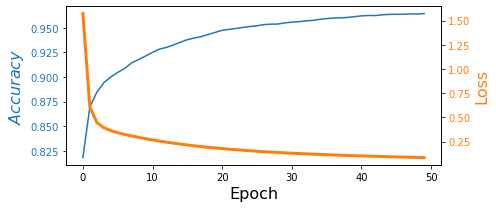

In [6]:
fig, ax1 = plt.subplots(figsize=(7,3))
fontsize=16
color = 'C0'
ax1.set_xlabel('Epoch',fontsize=fontsize)
ax1.set_ylabel(r'$Accuracy$', color=color,fontsize=fontsize)
ax1.plot(np.asarray(acc), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'C1'
ax2.set_ylabel('Loss', color=color,fontsize=fontsize)  # we already handled the x-label with ax1
ax2.plot(np.asarray(loss),c=color,linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Here is the function that calculates the FIM matrix. 

In [7]:
def calculate_FIM(model: nn.Module, 
                  data_loader: torch.utils.data.DataLoader):
    
    device=model.device
    model.eval()
    grad=[]
    for n, p in model.named_parameters():
        grad.append(p.grad.data.view(-1))            
    grad=torch.cat(grad)
    d=grad.shape[0]
    A=torch.zeros((d,d))
        
    for i,(imgs,labels) in tqdm(enumerate(data_loader)):
        model.zero_grad() # Zero the gradients
        imgs,labels = imgs.to(device),labels.to(device)# Get Inout

        loss=nn.CrossEntropyLoss()(model(imgs).to(device),labels.to(device))
        loss.backward()
        
        grad=[]
        for n, p in model.named_parameters():
            grad.append(p.grad.data.view(-1))            
        grad=torch.cat(grad).cpu()
        A+=torch.matmul(grad.unsqueeze(1).cpu(),grad.unsqueeze(0).cpu())
    A=A/float(i+1)
    return A

In [8]:
# Calculate the FIM
A=calculate_FIM(model=model,data_loader=train_loader[task])

In [9]:
np.save(open(results_folder+'FIM.npy','wb'),A)

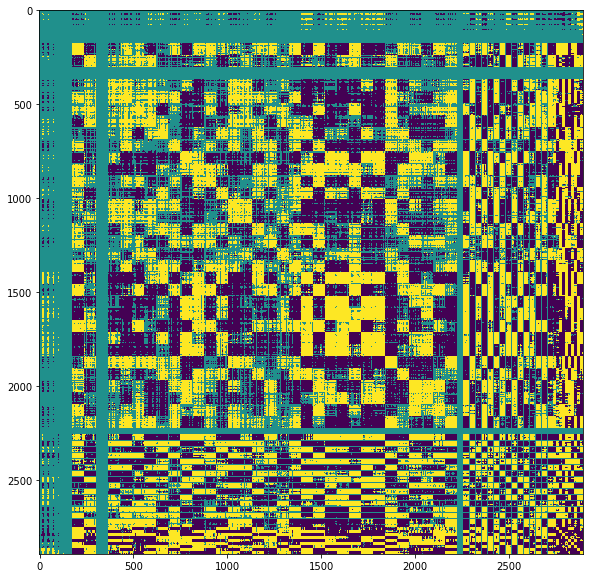

In [11]:
B=A.clone()
vis_thresh=1e-5
B=np.sign(B)*(abs(B)>vis_thresh)
fig=plt.figure(figsize=(10,10))
osetx=50000
osety=osetx
plt.imshow(B[osetx:-1,osety:-1])

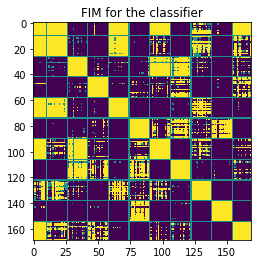

In [12]:
# Classifier is 16->10 which has 160 synapses and 10 biases
plt.imshow(B[-170:-1,-170:-1])
plt.title('FIM for the classifier')
plt.show()

In [14]:
from sklearn.decomposition import TruncatedSVD

In [19]:
svd = TruncatedSVD(n_components=500)
svd.fit(B)
print(svd.singular_values_)

[3422.8442   2296.666    1948.4338   1942.7886   1454.35     1404.7865
 1140.1492    923.6072    831.29333   803.4618    677.00433   564.7222
  555.206     529.2798    514.6303    503.92776   481.3319    457.35544
  446.66797   423.8145    420.85614   400.68344   383.63248   373.98218
  371.09067   353.9915    345.9916    339.06784   330.47644   328.60214
  322.9007    311.84537   305.22363   302.42566   295.18225   285.5802
  278.75348   273.71802   272.42148   268.72287   267.59113   258.5026
  257.55368   255.58032   254.14548   248.37415   240.84163   240.40517
  238.90594   236.53395   234.62775   233.93951   230.54135   224.71396
  223.54095   218.29941   217.93991   216.59528   215.91716   213.25919
  212.0664    207.80002   203.9996    203.92294   198.96982   198.33995
  197.24753   194.4014    192.86465   191.41425   191.26929   190.28952
  188.08176   185.81207   184.7486    182.5053    182.44287   180.82304
  178.74365   178.37772   175.53606   175.15666   174.66888   173.23

<BarContainer object of 100 artists>

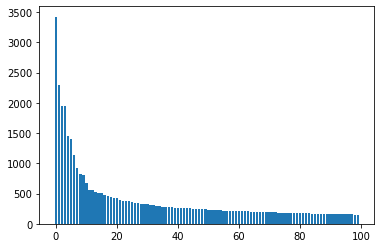

In [21]:
plt.bar(range(len(svd.singular_values_[:100])), svd.singular_values_[:100])